In [2]:
import sqlite3
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

def run_query(query):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(query, conn)
    
def run_command(command):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(command)
        
def show_tables():
    return(run_query('''SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");'''))

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [2]:
genres='''
WITH genre_tracks AS
(
SELECT SUM(invoice_line.quantity) tracks_sold, genre.name genre
FROM invoice_line
INNER JOIN invoice on invoice.invoice_id=invoice_line.invoice_id
INNER JOIN customer on customer.customer_id=invoice.customer_id
INNER JOIN track ON invoice_line.track_id=track. track_id
INNER JOIN genre ON track.genre_id=genre.genre_id
WHERE customer.country="USA"
GROUP BY genre.name
)
SELECT genre.name genre, genre_tracks.tracks_sold, 
(CAST(genre_tracks.tracks_sold as FLOAT)/SUM(invoice_line.quantity))*100 percentage_of_usa_sales
FROM genre
INNER JOIN track ON invoice_line.track_id=track.track_id
INNER JOIN invoice_line ON invoice_line.track_id=track.track_id
INNER JOIN invoice ON invoice_line.invoice_id=invoice.invoice_id
INNER JOIN customer ON customer.customer_id=invoice.customer_id
INNER JOIN genre_tracks ON genre.name=genre_tracks.genre
WHERE customer.country="USA"
GROUP BY genre.name'''
genres=run_query(genres)
genres

,genre,tracks_sold,percentage_of_usa_sales
0,Alternative,35,3.330162
1,Alternative & Punk,130,12.369172
2,Blues,36,3.425309
3,Classical,4,0.380590
4,Easy Listening,13,1.236917
5,Electronica/Dance,5,0.475737
6,Heavy Metal,3,0.285442
7,Hip Hop/Rap,20,1.902950
8,Jazz,14,1.332065
9,Latin,22,2.093245


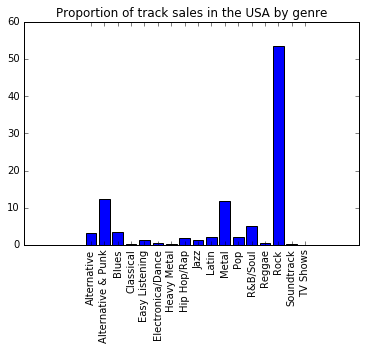

In [3]:
import numpy as np
x=np.arange(0,len(genres))
plt.bar(x,genres['percentage_of_usa_sales'], align='center', tick_label=genres['genre'])
plt.xticks(rotation=90)
plt.title('Proportion of track sales in the USA by genre')



In [26]:
'''The biggest genres in the US are Rock, Alternative & Punk, and Metal. Based on that, Chinook should purchase the albums from Red Tone as it is in the Punk genre.  '''

'The biggest genres in the US are Rock, Alternative & Punk, and Metal. Based on that, Chinook should purchase the albums from Red Tone as it is in the Punk genre.  '

In [33]:
sales='''
SELECT e.first_name||" "||e.last_name employee_name, 
SUM(invoice.total) total_sales, e.hire_date 
FROM employee e 
INNER JOIN customer ON e.employee_id=customer.support_rep_id
INNER JOIN invoice ON customer.customer_id=invoice.customer_id
GROUP BY employee_name
'''

sales=run_query(sales)
sales

,employee_name,total_sales,hire_date
0,Jane Peacock,1731.51,2017-04-01 00:00:00
1,Margaret Park,1584.00,2017-05-03 00:00:00
2,Steve Johnson,1393.92,2017-10-17 00:00:00


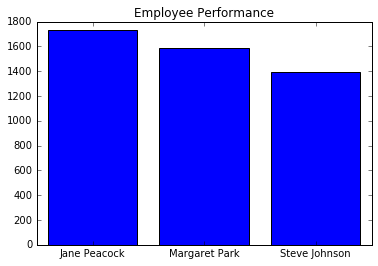

In [35]:
x=np.arange(3)
plt.bar(x, sales['total_sales'], align='center', tick_label=sales['employee_name'])
plt.title("Employee Performance")

In [38]:
'''The way the query is set up right now, we can\'t determine who the best-performing sales support agent is. The total amount sold is highest for the employees that have been hired the longest. If we restricted the date range and counted invoices only within that date range, we could get a better measure.'''

"The way the query is set up right now, we can't determine who the best-performing sales support agent is. The total amount sold is highest for the employees that have been hired the longest. If we restricted the date range and counted invoices only within that date range, we could get a better measure."

In [26]:
country_data='''
WITH calc AS 
(
SELECT 
COUNT(DISTINCT(customer.customer_id)) number_of_customers,
SUM(invoice.total) total,
country,
COUNT(invoice.invoice_id) invoice_count
FROM customer
INNER JOIN invoice ON customer.customer_id=invoice.customer_id
GROUP BY country
), by_country AS
(
SELECT CASE WHEN number_of_customers=1 THEN "OTHER" ELSE calc.country END AS country,
number_of_customers,total, invoice_count
FROM calc
GROUP BY country
), country_cols AS
(
SELECT by_country.country,SUM(by_country.number_of_customers) customers, 
SUM(by_country.total) total_sales, SUM(by_country.invoice_count) invoice_count 
FROM by_country
GROUP BY by_country.country
), unsorted AS(
SELECT country_cols.country, country_cols.customers, country_cols.total_sales,
country_cols.total_sales/country_cols.customers average_sales_per_customer, 
country_cols.total_sales/country_cols.invoice_count average_order_value
FROM country_cols
GROUP BY country_cols.country
ORDER BY total_sales
)

SELECT country, customers, total_sales, average_sales_per_customer, 
average_order_value 
FROM (
    SELECT
        unsorted.*,
        CASE
            WHEN unsorted.country="OTHER" THEN 1
            ELSE 0
        END AS sort
        FROM unsorted
)
ORDER BY sort ASC
'''

country_data=run_query(country_data)
country_data

,country,customers,total_sales,average_sales_per_customer,average_order_value
0,India,2,183.15,91.575000,8.721429
1,Portugal,2,185.13,92.565000,6.383793
2,United Kingdom,3,245.52,81.840000,8.768571
3,Czech Republic,2,273.24,136.620000,9.108000
4,Germany,4,334.62,83.655000,8.161463
5,France,5,389.07,77.814000,7.781400
6,Brazil,5,427.68,85.536000,7.011148
7,Canada,8,535.59,66.948750,7.047237
8,USA,13,1040.49,80.037692,7.942672
9,OTHER,15,1094.94,72.996000,7.448571


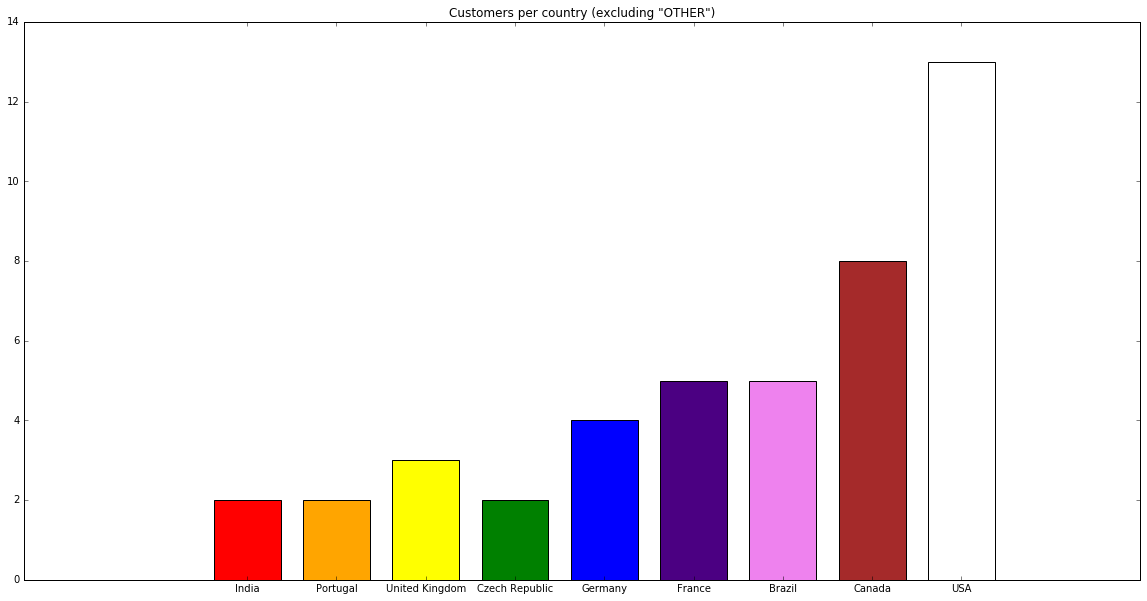

In [58]:
x=np.arange(0,(len(country_data['country'])-1)*2, 2)
colors=['red','orange','yellow','green','blue','indigo','violet','brown','white','black']
plt.figure(figsize=(20,10))
plt.bar(x,country_data.iloc[0:9]['customers'], 1.5,align='center', 
        tick_label=country_data.iloc[0:9]['country'], color=colors)
plt.title('Customers per country (excluding "OTHER")')


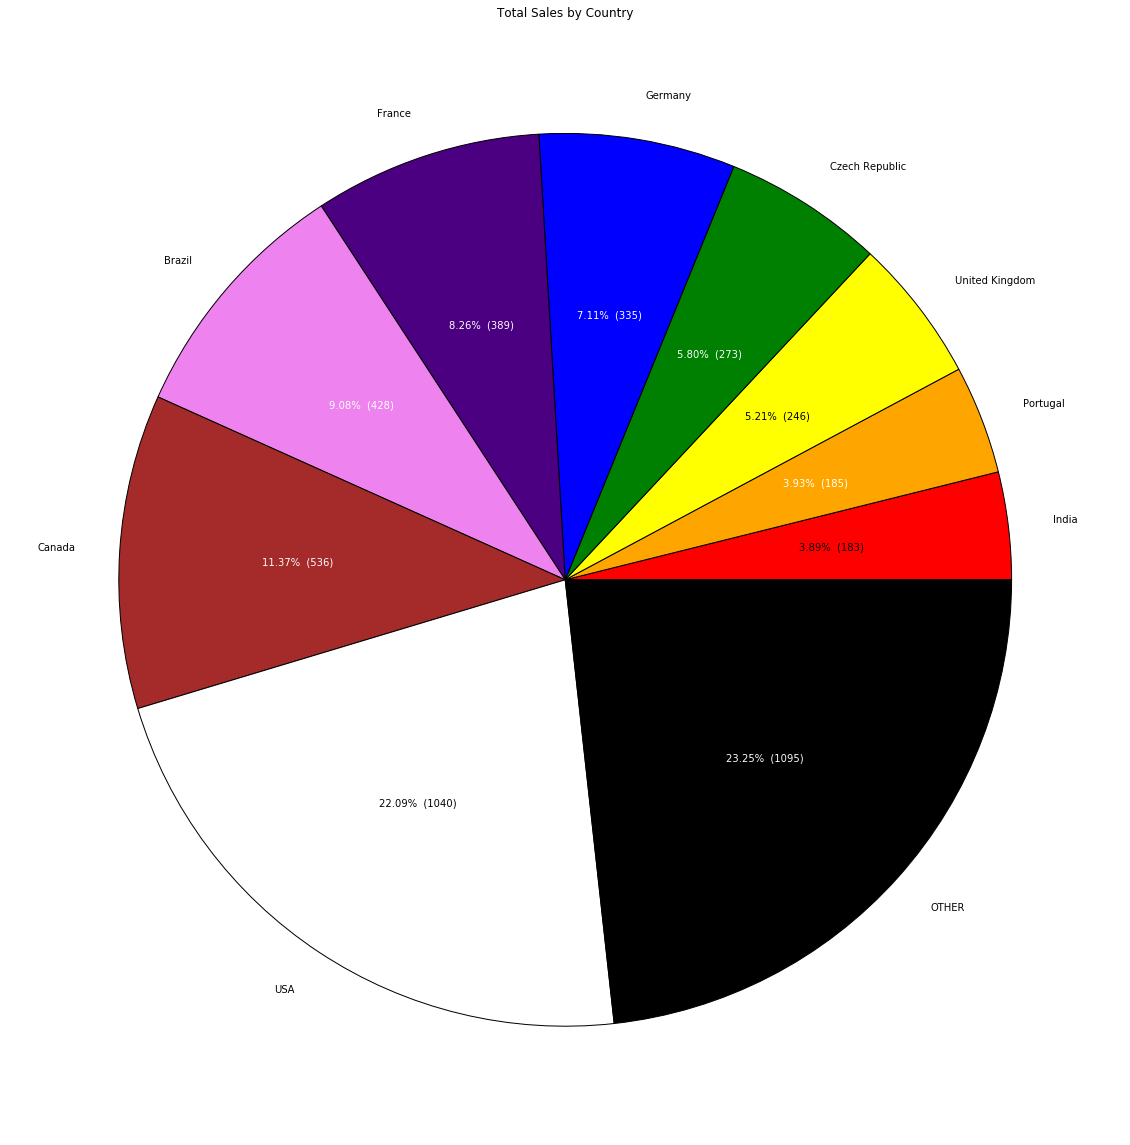

In [87]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

plt.figure(figsize=(20,20))
_, _, autotexts=plt.pie(country_data['total_sales'], colors=colors, 
        labels=country_data['country'], 
       autopct=make_autopct(country_data['total_sales']))
plt.title('Total Sales by Country')
for x in [1,3,4,5,6,7,9]:
    autotexts[x].set_color('white')

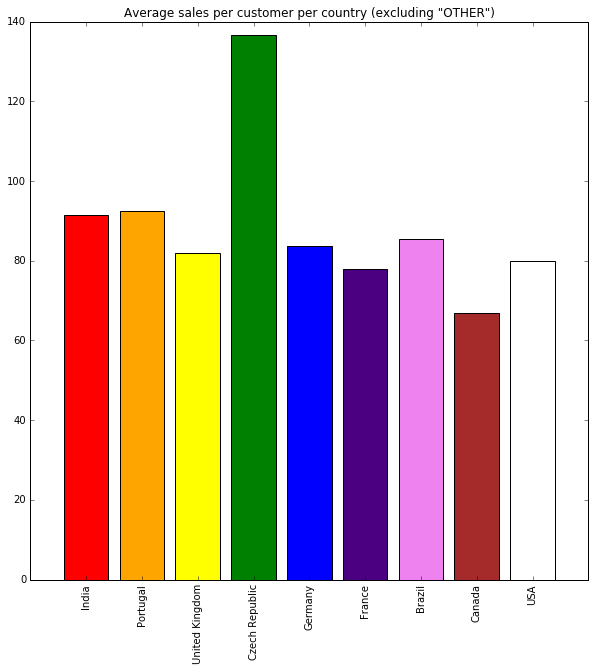

In [83]:
plt.figure(figsize=(10,10))
x=np.arange(0,len(country_data['country'])-1)
plt.bar(x,country_data.iloc[0:9]['average_sales_per_customer'],color=colors,
       align='center', tick_label=country_data.iloc[0:9]['country'])
plt.xticks(rotation=90)
plt.title('Average sales per customer per country (excluding "OTHER")')

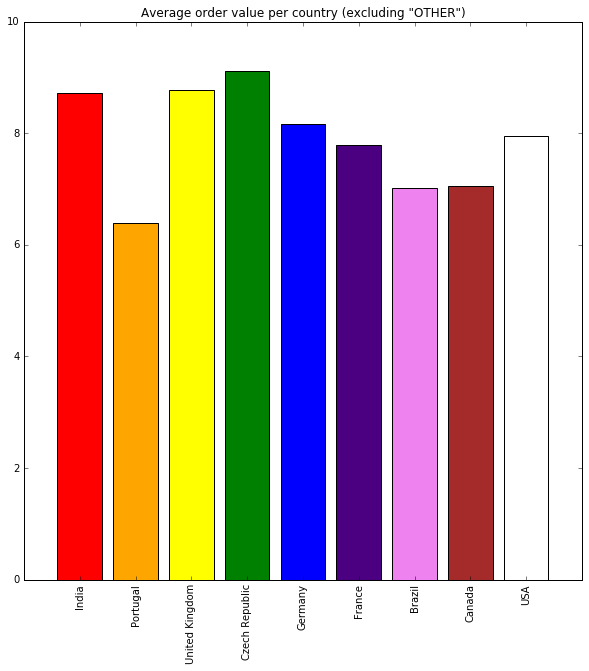

In [84]:
plt.figure(figsize=(10,10))
x=np.arange(0,len(country_data['country'])-1)
plt.bar(x,country_data.iloc[0:9]['average_order_value'],color=colors,
       align='center', tick_label=country_data.iloc[0:9]['country'])
plt.xticks(rotation=90)
plt.title('Average order value per country (excluding "OTHER")')

In [ ]:
"""India has among the highest avg sales per customer and avg order value per country. 
Yet it has among the lowest current customers. India has potential for growth. The Czech 
Republic is the most profitable country, yet it also only has two customers. Drawing more 
high-spending customers from that country would bring growth. """

In [17]:
all_invoices="""
SELECT COUNT(invoice.invoice_id) FROM invoice"""
albums_from_all_invoices="""
    SELECT track.album_id FROM invoice 
    INNER JOIN invoice_line ON invoice.invoice_id=invoice_line.invoice_id
    INNER JOIN track ON invoice_line.track_id=track.track_id
"""

one_album_per_invoice="""
    SELECT track.album_id,invoice.invoice_id FROM invoice
    INNER JOIN invoice_line ON invoice.invoice_id=invoice_line.invoice_id
    INNER JOIN track ON invoice_line.track_id=track.track_id
    GROUP BY invoice.invoice_id
"""
all_tracks_from_selected_invoice_albums="""
WITH one_album_per_invoice AS(
    SELECT track.album_id,invoice.invoice_id FROM invoice
    INNER JOIN invoice_line ON invoice.invoice_id=invoice_line.invoice_id
    INNER JOIN track ON invoice_line.track_id=track.track_id
    GROUP BY invoice.invoice_id
    )
SELECT track.track_id,COUNT(DISTINCT(one_album_per_invoice.album_id))
FROM track 
INNER JOIN one_album_per_invoice ON 
one_album_per_invoice.album_id=track.album_id
"""

test="""
WITH one_album_per_invoice AS(
    SELECT track.album_id,invoice.invoice_id FROM invoice
    INNER JOIN invoice_line ON invoice.invoice_id=invoice_line.invoice_id
    INNER JOIN track ON invoice_line.track_id=track.track_id
    GROUP BY invoice.invoice_id
    )
SELECT track.track_id,one_album_per_invoice.album_id
FROM track 
INNER JOIN one_album_per_invoice ON 
one_album_per_invoice.album_id=track.album_id

EXCEPT

SELECT track.track_id, track.album_id FROM invoice_line
INNER JOIN track ON invoice_line.track_id=track.track_id
"""

all_tracks="""
SELECT COUNT(DISTINCT(track_id)), COUNT(DISTINCT(album_id)) FROM track
"""
run_query(all_tracks_from_selected_invoice_albums) 

,track_id,COUNT(DISTINCT(one_album_per_invoice.album_id))
0,2663,166


3503 distinct tracks. 347 distinct albums. 
2108 distinct tracks from 166 distinct albums (randomly?) chosen from invoices. The selection of total tracks from all invoices is more numerous than the total number of tracks. 